In [1]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter, time_trace
#from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter
from pytopo.qctools import instruments as instools
import utils
from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path
from qcodes.dataset.data_export import get_shaped_data_by_runid, get_data_by_id
from qcodes.dataset.data_set import load_by_id


from data_analysis.tools import curr2cond, smooth

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
m = 9.11e-31
h = 6.623e-34
h_bar = h/(2*np.pi)
e = 1.602e-19
E_F = 100e-3*e #J
m_eff = 0.023*m

v_F = np.sqrt(2*E_F/m_eff)

G0 = 2*e**2/h

In [3]:
from utils.utils import dic_data
from utils.utils.dic_data import dic2hdf5, data
import scipy.optimize as spy

## Load data file and list parameters

In [3]:
dat1 = load_by_id(680)
R_s = 25.4e3 # series R in Ohm
V_bias = 10e-3 #bias voltage in V
exc = 20e-6
dat1.get_parameters()

[mdac_gate_voltage (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

## Basic plotting: no R_S subtraction

<IPython.core.display.Javascript object>


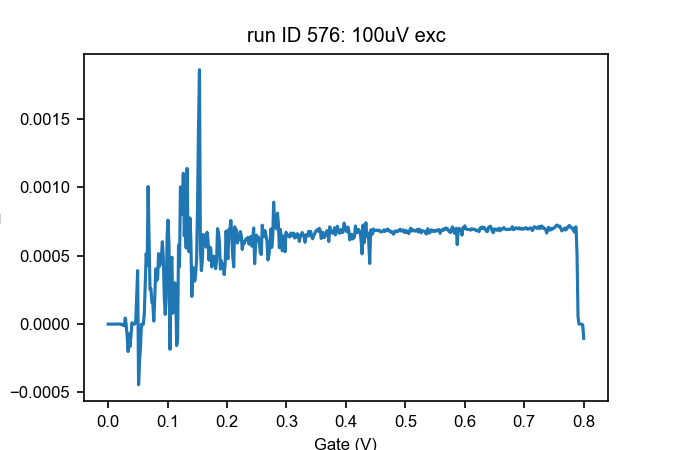

Text(0,0.5,'Lockin1_X (V)')

In [26]:
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))[:,0]
current_values = np.array(dat1.get_values('Lockin1_X'))[:,0]
plt.figure()
plt.plot(gate_values, current_values)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ': 100uV exc')
plt.xlabel('Gate (V)')
plt.ylabel('Lockin1_X (V)')

## With $R_s$ subtraction - lock in

<IPython.core.display.Javascript object>


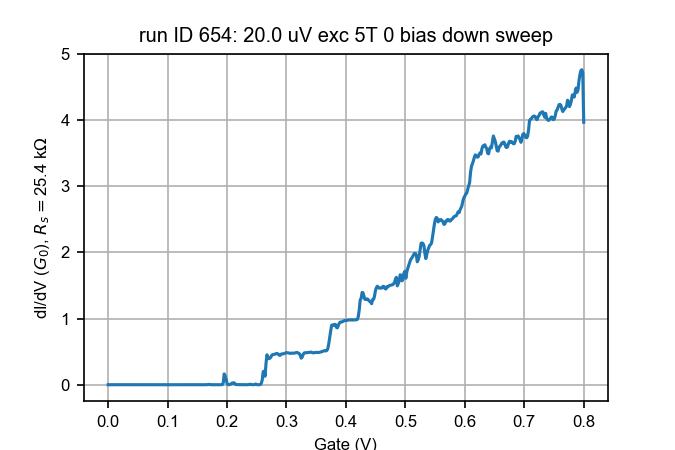

In [593]:
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))[:,0]
conductance_values = np.array(dat1.get_values('Lockin1_X'))[:,0]
res = (exc/(conductance_values/1e6) - R_s)/12906
plt.figure()
plt.plot(gate_values, 1/res)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ': ' + str(exc*1e6) + ' uV exc 5T 0 bias down sweep')
plt.xlabel('Gate (V)')
plt.ylabel('dI/dV ($G_0$), $R_s=$' + str(R_s/1e3) + ' k$\Omega$')
plt.grid(b=True)
#plt.ylim(-0.5,5)

## With $R_s$ subtraction - DC

<IPython.core.display.Javascript object>


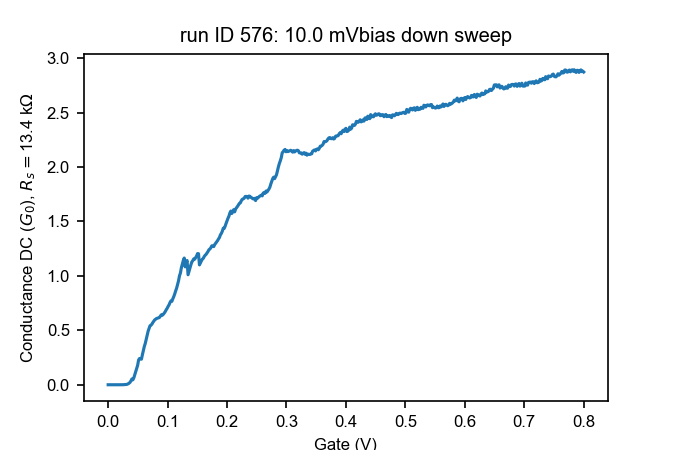

Text(0,0.5,'Conductance DC ($G_0$), $R_s=$13.4 k$\\Omega$')

In [44]:
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))[:,0]
current_values = np.array(dat1.get_values('current'))[:,0]
res = (V_bias/current_values - R_s)/12906
plt.figure()
plt.plot(gate_values, 1/res)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ': ' + str(V_bias*1e3) + ' mVbias down sweep')
plt.xlabel('Gate (V)')
plt.ylabel('Conductance DC ($G_0$), $R_s=$' + str(R_s/1e3) + ' k$\Omega$')
#plt.ylim(-0.5,6)

## Up and down sweeps in one run

In [31]:
1/((5e-3/1e-7-23.4e3)/12906)

0.485187969924812

In [12]:
dat1.run_id

680

<IPython.core.display.Javascript object>


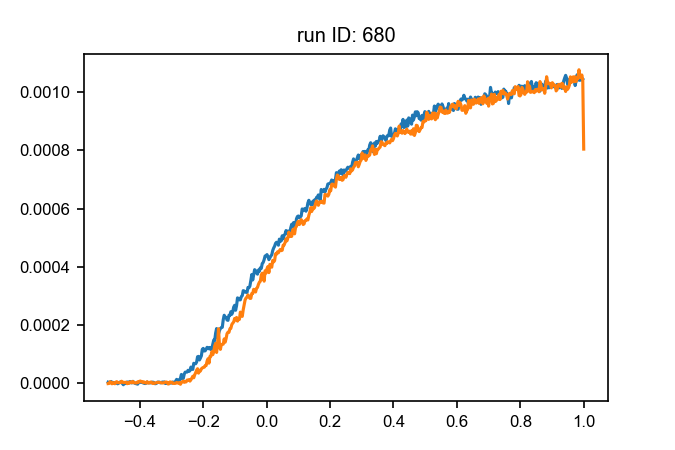

In [14]:
# splitting up and down sweeps
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))
current_values = np.array(dat1.get_values('Lockin1_X'))
npoints = int(gate_values.size/2)
gate_down = gate_values[0:npoints]
current_down = current_values[0:npoints]
gate_up = gate_values[npoints:-1]
current_up = current_values[npoints:-1]
plt.figure('testwater')
plt.title('run ID: {}'.format(dat1.run_id))
plt.plot(gate_up, current_up, gate_down, current_down)

## Up and down in two runs

In [29]:
dat1 = load_by_id(602)
dat2 = load_by_id(603)
R_s = 13.4e3 # series R in Ohm
V_bias = 10e-3 #bias voltage in V
dat1.get_parameters()

[mdac_gate_voltage (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

<IPython.core.display.Javascript object>


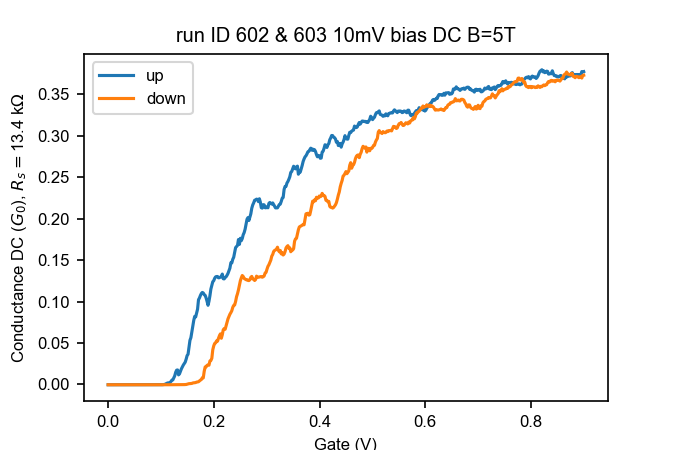

In [30]:
gate_up = np.array(dat1.get_values('mdac_gate_voltage'))[:,0]
current_up = np.array(dat1.get_values('current'))[:,0]
gate_down = np.array(dat2.get_values('mdac_gate_voltage'))[:,0]
current_down = np.array(dat2.get_values('current'))[:,0]

conductance_dc_up = 12906/(V_bias/current_up - R_s)
conductance_dc_down = 12906/(V_bias/current_down - R_s)

plt.figure('10mV hysteresis')
plt.plot(gate_up, conductance_dc_up, gate_down, conductance_dc_down)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ' & ' + '{}'.format(dat2.run_id) + ' 10mV bias DC B=5T')
plt.xlabel('Gate (V)')
plt.ylabel('Conductance DC ($G_0$), $R_s=$' + str(R_s/1e3) + ' k$\Omega$')
plt.legend(['up', 'down'])

### gate leakage

<IPython.core.display.Javascript object>


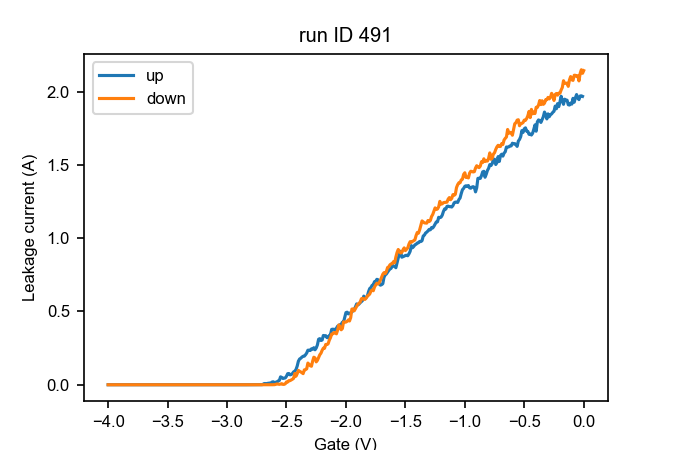

In [577]:
#conductance_up = current_up/(V_bias - current_up*R_s)
#conductance_down = current_down/(V_bias - current_down*R_s)

plt.figure('Leakage current')
plt.plot(gate_up, current_up, gate_down, current_down)
plt.title('run ID ' + '{}'.format(dat1.run_id))
plt.xlabel('Gate (V)')
plt.ylabel('Leakage current (A)')
plt.legend(['up', 'down'])

In [580]:
np.append(np.linspace(4, 0, 8), np.linspace(0, 4, 8))

array([4.        , 3.42857143, 2.85714286, 2.28571429, 1.71428571,
       1.14285714, 0.57142857, 0.        , 0.        , 0.57142857,
       1.14285714, 1.71428571, 2.28571429, 2.85714286, 3.42857143,
       4.        ])

## Pinchoff with $R_\text{series}$ correction

To do: add mobility fitting

<IPython.core.display.Javascript object>


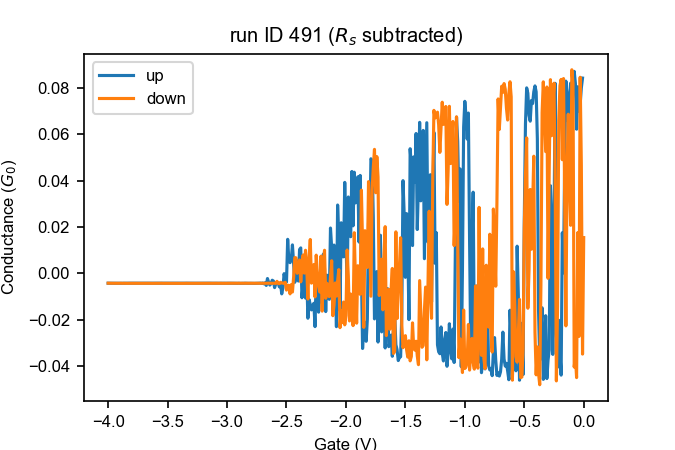

In [575]:
conductance_up = current_up/(V_bias - current_up*R_s)
conductance_down = current_down/(V_bias - current_down*R_s)
plt.figure('conductance minus R_s')
plt.plot(gate_up, conductance_up*12906, gate_down, conductance_down*12906)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ' ($R_s$ subtracted)')
plt.xlabel('Gate (V)')
plt.ylabel('Conductance ($G_0$)')
plt.legend(['up', 'down'])

## 2D plots

In [579]:
from qcodes.dataset.experiment_container import Experiment
dat2D = load_by_id(656)
exp = Experiment(dat2D.path_to_db)
exp.exp_id = dat2D.exp_id
dat2D.exp_name = exp.name

R_s = 25.4e3 # series R in Ohm
dat2D.get_parameters()

[mdac_gate_voltage (numeric),
 lockin_dc (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

In [580]:
inner_loop_values = np.unique(dat2D.get_values('lockin_dc'))
outer_loop_values = np.unique(dat2D.get_values('mdac_gate_voltage'))
lockin_X = np.array(dat2D.get_values('Lockin1_X'))[:,0].reshape((inner_loop_values.size, outer_loop_values.size))
lockin_X.shape


(301, 401)

In [583]:
def colorplot(data, fast_s, slow_s, z, AC='True'):
    fig=plt.figure()
    plt.title('run ID ' + '{}, '.format(data.run_id) + str(dat2D.exp_name)+ ' : 20uV exc')
    #data = data[0]
    fs = np.unique(data.get_values(fast_s))
    ss = np.unique(data.get_values(slow_s))
    #print((data.get_values(slow_s)))
    data_z = np.array(data.get_values(z))  
    r_line = 25.4e3
    conductance = 12906/(2e-5/(data_z/1e6) - r_line)
    print(min(conductance), max(conductance))
    cmap = plt.cm.seismic #seismic, viridis, magma
    norm = mpl.colors.Normalize(vmin=-0.5, vmax=3)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel('dI/dV ($G_0$)')
    plt.pcolor(np.unique(fs)[::-1]*1e3, np.unique(ss)[::-1], np.reshape(conductance,(len(np.unique(ss)),len(np.unique(fs)))), cmap=cmap, norm=norm)
    #plt.xlabel(fast_s + ' (V)')
    #plt.ylabel(slow_s + ' (V)')
    plt.xlabel('Bias (mV)')
    plt.ylabel('Gate (V)')
    plt.tight_layout()
    plt.savefig(r'D:\Data\images\20180711_' + str(dat2D.exp_name) +'.png')
    #plt.xlim(-0.011,0.011)
    #plt.ylim(0.1,0.3)

<IPython.core.display.Javascript object>


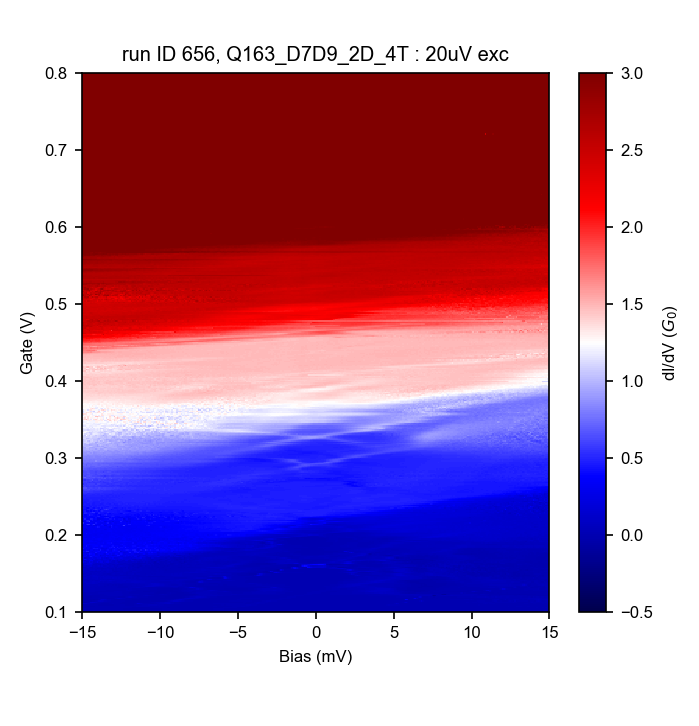

[-0.13073766] [9.53477112]


In [584]:
colorplot(dat2D, 'lockin_dc', 'mdac_gate_voltage', 'Lockin1_X')

### 1D from 2D plot

In [290]:
def plot1D_from_2D(data, x, y, x2, index):
    b = np.unique(np.array(data.get_values(x))) #[::-1]
    print(b)
    npoints = len(b)
    v2 = np.array(data.get_values(x2))
    x2_value = v2[index*npoints]
    points = v2 == v2[index*npoints]#x2_value #np.abs((v2 - x2_value)/x2_value) < 1e-6 #v2 == x2_value   # np.abs((v2 - x2_value)/x2_value) < 1e-6
    
    #plt.plot(points)
    g = np.array(data.get_values(y))
    g = g[points]
    #g = smooth(g, 21, 3)
    #g_sub = curr2cond(g, 20e-6, 15e3)
    #print(b, g)
    print(x2_value)
    plt.plot(b, g[::-1], label=x2+' = '+str(x2_value)[1:4]+' T')
    plt.xlabel(x+' (V)')
    plt.ylabel('dI/dV (G0)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(r'D:\Data\images\20180711_' + str(dat2D.exp_name) + '_%.3fT.png'%(x2_value))
    
    #return b #, g_sub

<IPython.core.display.Javascript object>


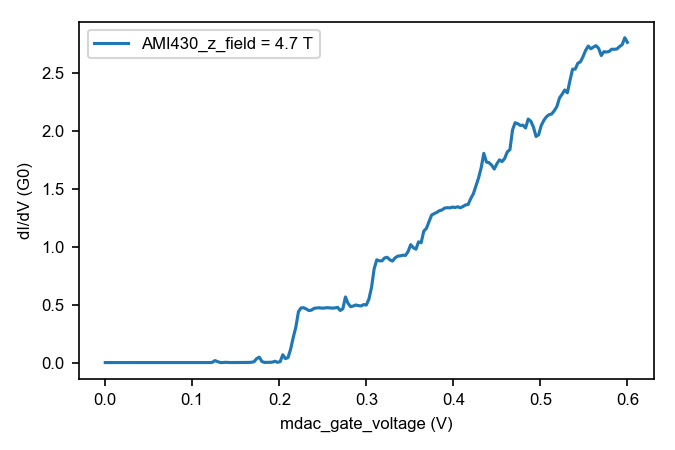

[0.    0.003 0.006 0.009 0.012 0.015 0.018 0.021 0.024 0.027 0.03  0.033
 0.036 0.039 0.042 0.045 0.048 0.051 0.054 0.057 0.06  0.063 0.066 0.069
 0.072 0.075 0.078 0.081 0.084 0.087 0.09  0.093 0.096 0.099 0.102 0.105
 0.108 0.111 0.114 0.117 0.12  0.123 0.126 0.129 0.132 0.135 0.138 0.141
 0.144 0.147 0.15  0.153 0.156 0.159 0.162 0.165 0.168 0.171 0.174 0.177
 0.18  0.183 0.186 0.189 0.192 0.195 0.198 0.201 0.204 0.207 0.21  0.213
 0.216 0.219 0.222 0.225 0.228 0.231 0.234 0.237 0.24  0.243 0.246 0.249
 0.252 0.255 0.258 0.261 0.264 0.267 0.27  0.273 0.276 0.279 0.282 0.285
 0.288 0.291 0.294 0.297 0.3   0.303 0.306 0.309 0.312 0.315 0.318 0.321
 0.324 0.327 0.33  0.333 0.336 0.339 0.342 0.345 0.348 0.351 0.354 0.357
 0.36  0.363 0.366 0.369 0.372 0.375 0.378 0.381 0.384 0.387 0.39  0.393
 0.396 0.399 0.402 0.405 0.408 0.411 0.414 0.417 0.42  0.423 0.426 0.429
 0.432 0.435 0.438 0.441 0.444 0.447 0.45  0.453 0.456 0.459 0.462 0.465
 0.468 0.471 0.474 0.477 0.48  0.483 0.486 0.489 0.

In [307]:
plt.figure()

#dat2D.get_parameters()#values('conductance')
plot1D_from_2D(dat2D, 'mdac_gate_voltage', 'conductance', 'AMI430_z_field', 7)
dat2D.run_id = 615


In [35]:
10e-3/5e-7

20000.0

In [17]:
plot1D_from_2D(dat1, 'gate_voltage', 'dI', 'bias_voltage', 0.003)

### View gate or bias setpoints

In [123]:
np.unique(dat2D.get_values('lockin_dc'))

array([-0.015  , -0.01485, -0.0147 , -0.01455, -0.0144 , -0.01425,
       -0.0141 , -0.01395, -0.0138 , -0.01365, -0.0135 , -0.01335,
       -0.0132 , -0.01305, -0.0129 , -0.01275, -0.0126 , -0.01245,
       -0.0123 , -0.01215, -0.012  , -0.01185, -0.0117 , -0.01155,
       -0.0114 , -0.01125, -0.0111 , -0.01095, -0.0108 , -0.01065,
       -0.0105 , -0.01035, -0.0102 , -0.01005, -0.0099 , -0.00975,
       -0.0096 , -0.00945, -0.0093 , -0.00915, -0.009  , -0.00885,
       -0.0087 , -0.00855, -0.0084 , -0.00825, -0.0081 , -0.00795,
       -0.0078 , -0.00765, -0.0075 , -0.00735, -0.0072 , -0.00705,
       -0.0069 , -0.00675, -0.0066 , -0.00645, -0.0063 , -0.00615,
       -0.006  , -0.00585, -0.0057 , -0.00555, -0.0054 , -0.00525,
       -0.0051 , -0.00495, -0.0048 , -0.00465, -0.0045 , -0.00435,
       -0.0042 , -0.00405, -0.0039 , -0.00375, -0.0036 , -0.00345,
       -0.0033 , -0.00315, -0.003  , -0.00285, -0.0027 , -0.00255,
       -0.0024 , -0.00225, -0.0021 , -0.00195, -0.0018 , -0.00

## exporting data

In [31]:
with open("B11B12 conductance_up.txt", "w") as text_file:
    for value in conductance_dc_up:
        text_file.write(str(value) + '\n')
with open("B11B12 conductance_down.txt", "w") as text_file:
    for value in conductance_dc_down:
        text_file.write(str(value) + '\n')

        
#with open("B13B14 gate_up.txt", "w") as text_file:
#    for value in gate_up:
#        text_file.write(str(value) + '\n')
#with open("B13B14 gate_down.txt", "w") as text_file:
#    for value in gate_down:
#        text_file.write(str(value) + '\n')


## Noise analysis

In [517]:
# importing data
from qcodes.dataset.experiment_container import Experiment
dat2D = load_by_id(633)
exp = Experiment(dat2D.path_to_db)
exp.exp_id = dat2D.exp_id
dat2D.exp_name = exp.name
print(dat2D.exp_name)
dat2D.get_parameters()

Q163_D7D9_bias_time


[lockin_dc (numeric),
 time_sweep (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

In [518]:
# getting the relevant vectors and matrices
inner_loop_values = np.unique(dat2D.get_values('time_sweep'))
outer_loop_values = np.unique(dat2D.get_values('lockin_dc'))
lockin_X = np.array(dat2D.get_values('Lockin1_X'))[:,0].reshape((outer_loop_values.size, inner_loop_values.size))
print(inner_loop_values.shape, outer_loop_values.shape, lockin_X.shape)

(201,) (51,) (51, 201)


<IPython.core.display.Javascript object>


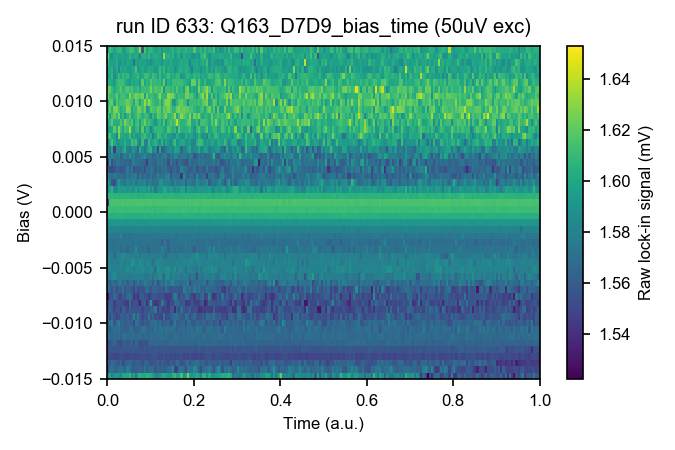

In [519]:
# plotting the raw data
plt.figure('noise')
plt.title('run ID ' + str(dat2D.run_id) + ': ' + str(dat2D.exp_name)+ ' (50uV exc)')

data_z = 1e3*lockin_X # V to mV
cmap = plt.cm.viridis #seismic, viridis, magma
norm = mpl.colors.Normalize(vmin=np.min(data_z), vmax=np.max(data_z))
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('Raw lock-in signal (mV)')
plt.pcolor(inner_loop_values, outer_loop_values, data_z, cmap=cmap, norm=norm)
plt.xlabel('Time (a.u.)')
plt.ylabel('Bias (V)')
#plt.ylabel('Lock-in frequency (Hz)')
plt.tight_layout()

<IPython.core.display.Javascript object>


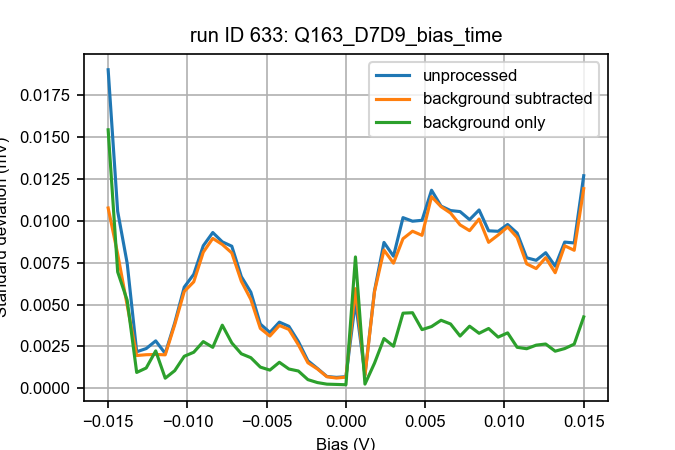

<IPython.core.display.Javascript object>


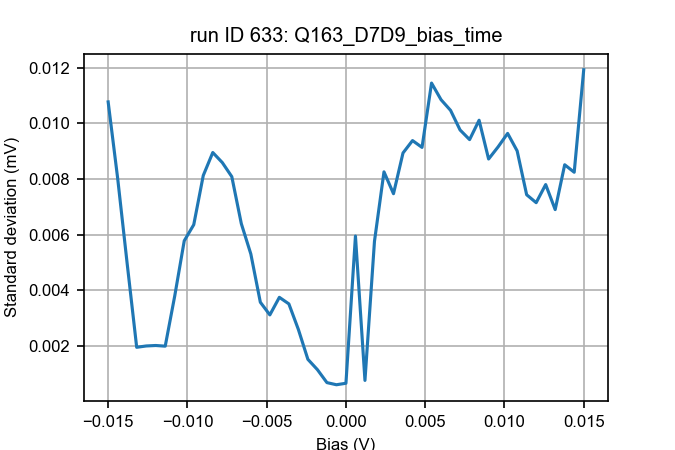

In [521]:
# simple statistics
std_vector_raw = np.std(data_z, axis=1)

data_z_bg = np.zeros(data_z.shape)
for kk in range(0, outer_loop_values.size):
    data_z_bg[kk,:] = smooth(data_z[kk,:], 11, 1)
data_z_residual = data_z - data_z_bg
std_vector_bg = np.std(data_z_bg, axis=1)
std_vector_residual = np.std(data_z_residual, axis=1)

plt.figure('noise stat all')
plt.title('run ID ' + str(dat2D.run_id) + ': ' + str(dat2D.exp_name))
plt.plot(outer_loop_values, std_vector_raw)
plt.plot(outer_loop_values, std_vector_residual)
plt.plot(outer_loop_values, std_vector_bg)
plt.xlabel('Bias (V)')
#plt.xlabel('Lock-in frequency (Hz)')
plt.ylabel('Standard deviation (mV)')
plt.grid(b=True)
plt.legend(['unprocessed', 'background subtracted', 'background only']) 

plt.figure('noise stat res')
plt.title('run ID ' + str(dat2D.run_id) + ': ' + str(dat2D.exp_name))
#plt.plot(outer_loop_values, std_vector_raw)
plt.plot(outer_loop_values, std_vector_residual)
#plt.plot(outer_loop_values, std_vector_bg)
plt.xlabel('Bias (V)')
#plt.xlabel('Lock-in frequency (Hz)')
plt.ylabel('Standard deviation (mV)')
plt.grid(b=True)

<IPython.core.display.Javascript object>


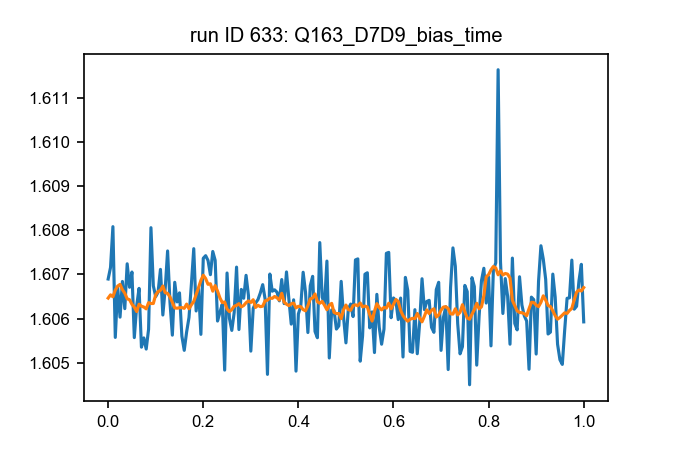

In [525]:
# example linecuts
plt.figure('bg subtraction visualization')
plt.title('run ID ' + str(dat2D.run_id) + ': ' + str(dat2D.exp_name))

line_num = 27
plt.plot(inner_loop_values, data_z[line_num, :])
plt.plot(inner_loop_values, data_z_bg[line_num, :])
#plt.plot(inner_loop_values, data_z_residual[line_num, :])